# Introduction

In this integrative work, we are going to propose a new implementation of an autoencoder to learn the MNIST database. We are going to mention the main reasons why we chose this model. We will detail what the topology of this new neural network is like and we will specify the chosen parameters that define how the learning stage will be carried out. We will continue to train the autoencoder and show relevant graphics such as Train Error vs. Test Error and Image Original vs. Reconstruction. Finally, we will make a comparison between this autoencoder and the one that was implemented in Practice 3 and we will make a conclusion about it.

# Previous Work

Recall that in Practical 3 an autoencoder with a fully-connected hidden layer was implemented. The disadvantage of this architecture is that the input image must be converted to a one-dimensional vector. This alteration generates the loss of spatiality since each neuron of the hidden layer will be "looking" at all the pixels of the input image.
This may be warning us that the topology of this neural network is not the most suitable for the processing and extraction of information from an image.

# New Proposal

Instead of using fully connected layers, we are going to use ***convolutional*** and ***pooling*** layers to reduce our input to an encoded representation. In this way, the image should no longer be converted to a one-dimensional vector and therefore the spatial information we continue to have.  
We believe that this factor can help improve the task of learning the identity function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.utils import make_grid
import torchvision.datasets as datasets
from torch import nn

In [1]:
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [5]:
NUM_EPOCHS = 50
LEARNING_RATE = 0.002
BATCH_SIZE = 1000

In [6]:
random_seed = 1
torch.manual_seed(random_seed)

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

In [7]:
mnist_data = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transform
)

mnist_test = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    mnist_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    mnist_test,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Convolutional Autoencoder

The proposed autoencoder implements two convolutional layers hidden in the encoder part. The first convolutional layer consists of 32 3x3 filters, while the second has 64 3x3 filters.  
Below is a diagram that describes the different transformations that the autoencoder performs from the original image.

![convnet_plot](convnet_plot.png)

Below is an example of how the operation that generates the increase in dimensionality (Upsampling) in the decoder part works:

In [8]:
A = torch.tensor([[[[1.,2.,3.],[4.,5.,6.],[7.,8.,9.]]]])
print(A)
B = nn.functional.interpolate(A, scale_factor=2, align_corners=True, mode='bilinear')
print(B)

tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])
tensor([[[[1.0000, 1.4000, 1.8000, 2.2000, 2.6000, 3.0000],
          [2.2000, 2.6000, 3.0000, 3.4000, 3.8000, 4.2000],
          [3.4000, 3.8000, 4.2000, 4.6000, 5.0000, 5.4000],
          [4.6000, 5.0000, 5.4000, 5.8000, 6.2000, 6.6000],
          [5.8000, 6.2000, 6.6000, 7.0000, 7.4000, 7.8000],
          [7.0000, 7.4000, 7.8000, 8.2000, 8.6000, 9.0000]]]])


Doing bilinear interpolation is equivalent to first doing linear interpolation on one dimension and then on the other.

$$
\begin{equation*}
y = y_1 + (x-x_1)\frac{y_2 - y_1}{x_2 - x_1}
\quad\quad\quad \text{(Linear interpolation)}
\end{equation*}
$$

***The following code defines the architecture of the autoencoder***

In [9]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()

        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.enconv1 = nn.Conv2d(1, 32, 3, padding=1)
        
        # conv layer (depth from 32 --> 64), 3x3 kernels
        self.enconv2 = nn.Conv2d(32, 64, 3, padding=1)
        
                       
        # pooling layer to reduce x-y dims by two; kernel
        # and stride of 2
        self.pool = nn.MaxPool2d(2, stride=2)     
        
        # conv layer (depth from 64 --> 32), 3x3 kernels
        self.deconv1 = nn.Conv2d(64, 32, 3, padding=1)
        
        # conv layer (depth from 32 --> 1), 3x3 kernels
        self.deconv2 = nn.Conv2d(32, 1, 3, padding=1)
        
        # activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        
        # ENCODER
        # image dimension -> (1,28,28)
        x = self.enconv1(x)
        x = self.relu(x)
        # (32,28,28)
        x = nn.MaxPool2d(2, stride=2)(x)
        # (32,14,14)
        x = self.enconv2(x)
        x = self.relu(x)
        # (64,14,14)
        x = self.pool(x)
        # (64,7,7)
        
        # DECODER
        x = nn.functional.interpolate(x, scale_factor=2, align_corners=True, mode='bilinear')
        # (64,14,14)
        x = self.deconv1(x)
        x = self.relu(x)
        # (32,14,14)
        x = nn.functional.interpolate(x, scale_factor=2, align_corners=True, mode='bilinear')
        # (32,28,28)
        x = self.deconv2(x)
        # (1,28,28)
        x = self.relu(x)
        
        return x

## Parameters

For the training of this network we will use:
* $50$ Epochs.
* Learning rate de $0.002$
* Batch size de $1000$

## Cost function and optimizer

For this autoencoder, the Mean Square Error (MSE) function is used as a cost function.

$$Error(x,\hat{x}) = \frac{1}{N}\sum_{i=0}^{N}{(x - \hat{x})^2}$$

On the other hand, the Adaptive Moment Estimation (Adam) variant of stochastic gradient descent (SGD) was used as optimizer.

In [10]:
model = Autoencoder().to(device)

In [11]:
criterion = nn.MSELoss()

In [12]:
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

In [13]:
train_loss = []
test_loss = []

for epoch in tqdm(range(NUM_EPOCHS)):

    # set the model in train mode   
    model.train()
    running_loss = 0.
    
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # set the gradients to zero
        optimizer.zero_grad()
        # feed the model with a batch of images
        outputs = model(img)
        # calculates the loss between output and input
        loss = criterion(outputs, img)
        # accumulates the gradient
        loss.backward()
        # parameters update
        optimizer.step()
        
        # accumulates the loss
        running_loss += loss.item()
    
    #computes the avg loss of the epoch (loss_0 + loss_1 + ... + loss_(n-1))/n
    train_loss.append(running_loss / len(train_loader))
    
    # set the model in evaluation mode
    model.eval()
    running_loss = 0.
    
    with torch.no_grad():
        for data in test_loader:
            img,_ = data
            img = img.to(device)
            outputs = model(img)
            loss = criterion(outputs, img)
            
            running_loss += loss.item()
        
        test_loss.append(running_loss / len(test_loader))
    
    print("epoch = {:02d}, train_loss = {:.3e}, test_loss = {:.3e}".format(epoch, train_loss[-1], test_loss[-1]))

  2%|▏         | 1/50 [00:17<14:19, 17.53s/it]

epoch = 00, train_loss = 4.876e-01, test_loss = 3.673e-01


  4%|▍         | 2/50 [00:34<13:59, 17.48s/it]

epoch = 01, train_loss = 3.384e-01, test_loss = 3.505e-01


  6%|▌         | 3/50 [00:52<13:40, 17.45s/it]

epoch = 02, train_loss = 3.027e-01, test_loss = 2.850e-01


  8%|▊         | 4/50 [01:09<13:20, 17.41s/it]

epoch = 03, train_loss = 2.821e-01, test_loss = 2.743e-01


 10%|█         | 5/50 [01:26<13:01, 17.37s/it]

epoch = 04, train_loss = 2.708e-01, test_loss = 2.613e-01


 12%|█▏        | 6/50 [01:44<12:43, 17.35s/it]

epoch = 05, train_loss = 2.636e-01, test_loss = 2.592e-01


 14%|█▍        | 7/50 [02:01<12:25, 17.33s/it]

epoch = 06, train_loss = 2.562e-01, test_loss = 2.533e-01


 16%|█▌        | 8/50 [02:18<12:07, 17.33s/it]

epoch = 07, train_loss = 2.520e-01, test_loss = 2.457e-01


 18%|█▊        | 9/50 [02:36<11:50, 17.33s/it]

epoch = 08, train_loss = 2.485e-01, test_loss = 2.418e-01


 20%|██        | 10/50 [02:53<11:34, 17.37s/it]

epoch = 09, train_loss = 2.420e-01, test_loss = 2.370e-01


 22%|██▏       | 11/50 [03:10<11:16, 17.34s/it]

epoch = 10, train_loss = 2.402e-01, test_loss = 2.339e-01


 24%|██▍       | 12/50 [03:28<10:58, 17.34s/it]

epoch = 11, train_loss = 2.359e-01, test_loss = 2.310e-01


 26%|██▌       | 13/50 [03:45<10:41, 17.34s/it]

epoch = 12, train_loss = 2.342e-01, test_loss = 2.286e-01


 28%|██▊       | 14/50 [04:03<10:26, 17.40s/it]

epoch = 13, train_loss = 2.307e-01, test_loss = 2.292e-01


 30%|███       | 15/50 [04:20<10:08, 17.37s/it]

epoch = 14, train_loss = 2.283e-01, test_loss = 2.272e-01


 32%|███▏      | 16/50 [04:37<09:50, 17.37s/it]

epoch = 15, train_loss = 2.295e-01, test_loss = 2.225e-01


 34%|███▍      | 17/50 [04:55<09:33, 17.37s/it]

epoch = 16, train_loss = 2.239e-01, test_loss = 2.207e-01


 36%|███▌      | 18/50 [05:12<09:14, 17.33s/it]

epoch = 17, train_loss = 2.234e-01, test_loss = 2.213e-01


 38%|███▊      | 19/50 [05:29<08:57, 17.35s/it]

epoch = 18, train_loss = 2.213e-01, test_loss = 2.178e-01


 40%|████      | 20/50 [05:47<08:40, 17.35s/it]

epoch = 19, train_loss = 2.197e-01, test_loss = 2.171e-01


 42%|████▏     | 21/50 [06:04<08:23, 17.35s/it]

epoch = 20, train_loss = 2.193e-01, test_loss = 2.178e-01


 44%|████▍     | 22/50 [06:21<08:04, 17.31s/it]

epoch = 21, train_loss = 2.174e-01, test_loss = 2.136e-01


 46%|████▌     | 23/50 [06:38<07:46, 17.29s/it]

epoch = 22, train_loss = 2.159e-01, test_loss = 2.143e-01


 48%|████▊     | 24/50 [06:56<07:29, 17.29s/it]

epoch = 23, train_loss = 2.149e-01, test_loss = 2.157e-01


 50%|█████     | 25/50 [07:13<07:11, 17.26s/it]

epoch = 24, train_loss = 2.137e-01, test_loss = 2.122e-01


 52%|█████▏    | 26/50 [07:30<06:54, 17.25s/it]

epoch = 25, train_loss = 2.127e-01, test_loss = 2.119e-01


 54%|█████▍    | 27/50 [07:47<06:36, 17.25s/it]

epoch = 26, train_loss = 2.118e-01, test_loss = 2.109e-01


 56%|█████▌    | 28/50 [08:05<06:19, 17.26s/it]

epoch = 27, train_loss = 2.113e-01, test_loss = 2.085e-01


 58%|█████▊    | 29/50 [08:22<06:02, 17.26s/it]

epoch = 28, train_loss = 2.099e-01, test_loss = 2.073e-01


 60%|██████    | 30/50 [08:39<05:45, 17.27s/it]

epoch = 29, train_loss = 2.097e-01, test_loss = 2.065e-01


 62%|██████▏   | 31/50 [08:56<05:27, 17.25s/it]

epoch = 30, train_loss = 2.081e-01, test_loss = 2.059e-01


 64%|██████▍   | 32/50 [09:14<05:11, 17.29s/it]

epoch = 31, train_loss = 2.107e-01, test_loss = 2.058e-01


 66%|██████▌   | 33/50 [09:31<04:53, 17.27s/it]

epoch = 32, train_loss = 2.067e-01, test_loss = 2.044e-01


 68%|██████▊   | 34/50 [09:48<04:35, 17.23s/it]

epoch = 33, train_loss = 2.058e-01, test_loss = 2.045e-01


 70%|███████   | 35/50 [10:05<04:17, 17.18s/it]

epoch = 34, train_loss = 2.057e-01, test_loss = 2.049e-01


 72%|███████▏  | 36/50 [10:22<04:00, 17.16s/it]

epoch = 35, train_loss = 2.053e-01, test_loss = 2.029e-01


 74%|███████▍  | 37/50 [10:39<03:42, 17.14s/it]

epoch = 36, train_loss = 2.046e-01, test_loss = 2.023e-01


 76%|███████▌  | 38/50 [10:57<03:25, 17.15s/it]

epoch = 37, train_loss = 2.040e-01, test_loss = 2.034e-01


 78%|███████▊  | 39/50 [11:14<03:08, 17.15s/it]

epoch = 38, train_loss = 2.039e-01, test_loss = 2.019e-01


 80%|████████  | 40/50 [11:31<02:51, 17.13s/it]

epoch = 39, train_loss = 2.030e-01, test_loss = 2.006e-01


 82%|████████▏ | 41/50 [11:48<02:34, 17.12s/it]

epoch = 40, train_loss = 2.028e-01, test_loss = 2.006e-01


 84%|████████▍ | 42/50 [12:05<02:17, 17.18s/it]

epoch = 41, train_loss = 2.024e-01, test_loss = 1.997e-01


 86%|████████▌ | 43/50 [12:22<02:00, 17.20s/it]

epoch = 42, train_loss = 2.033e-01, test_loss = 2.018e-01


 88%|████████▊ | 44/50 [12:40<01:43, 17.17s/it]

epoch = 43, train_loss = 2.015e-01, test_loss = 1.990e-01


 90%|█████████ | 45/50 [12:57<01:25, 17.19s/it]

epoch = 44, train_loss = 2.005e-01, test_loss = 2.000e-01


 92%|█████████▏| 46/50 [13:14<01:08, 17.19s/it]

epoch = 45, train_loss = 2.007e-01, test_loss = 1.989e-01


 94%|█████████▍| 47/50 [13:31<00:51, 17.22s/it]

epoch = 46, train_loss = 2.001e-01, test_loss = 1.981e-01


 96%|█████████▌| 48/50 [13:49<00:34, 17.23s/it]

epoch = 47, train_loss = 1.992e-01, test_loss = 1.982e-01


 98%|█████████▊| 49/50 [14:06<00:17, 17.23s/it]

epoch = 48, train_loss = 1.995e-01, test_loss = 1.973e-01


100%|██████████| 50/50 [14:23<00:00, 17.27s/it]

epoch = 49, train_loss = 1.994e-01, test_loss = 1.974e-01


## Results

### Training error vs. test error

The training error and the test error are shown below in the same graph.

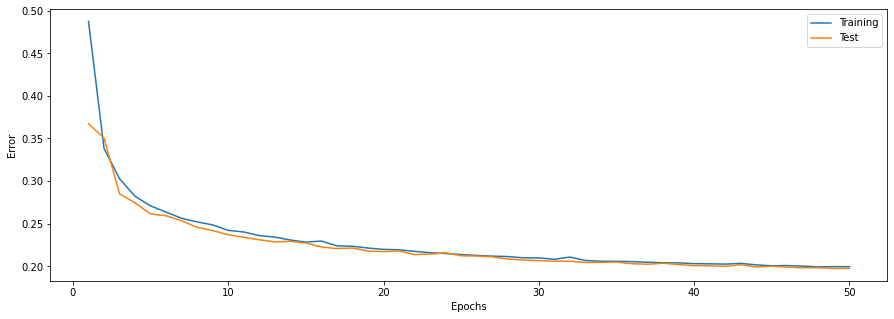

In [14]:
epochs = [i for i in range(1,NUM_EPOCHS+1)]

fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel('Epochs')
ax.set_ylabel('Error')

ax.plot(epochs, train_loss, label='Training')
ax.plot(epochs, test_loss, label='Test')

ax.legend()
plt.show()

We can see that the training error decreases monotonously as the epochs progress. From the graph of these curves, we can see that the model is learning correctly. There is no evidence that the network is over-fitting.

### Original image vs. Reconstruction

Below we will show examples of the test set with their respective reconstructions. This allows us to see if the neural network is learning the identity function.

In [15]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

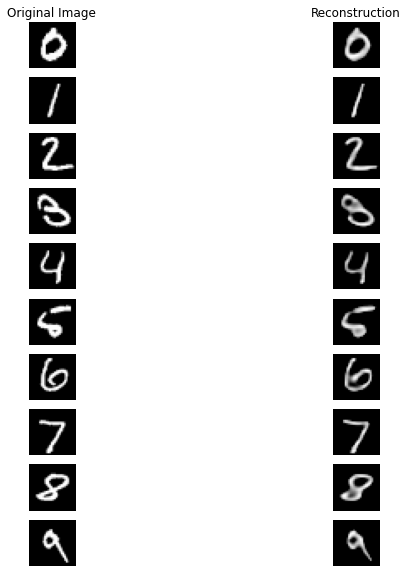

In [16]:
model.eval()

fig, ax = plt.subplots(10, 2, figsize=(10, 10))

# j = idx[i] => given the digit i(=0,1,...,9)
#               j will have position where that digit is in the dataset
idx = [3,2,1,18,4,8,11,0,61,7]

for i,j in enumerate(idx):
    img = mnist_test[j][0]
    output = model(img.view(1,1,28,28).to(device))
    ax[i][0].imshow(img.squeeze(),cmap='gray')
    ax[i][1].imshow(output.cpu().detach().squeeze(),cmap='gray')
    ax[i][0].axis('off');ax[i][1].axis('off')
ax[0][0].set_title("Original Image")
ax[0][1].set_title("Reconstruction")

plt.show()

On the left column, we can see a sample of each digit extracted from the test set. In the right column, we have the corresponding reconstruction of each digit.

# Comparison 

An important aspect to take into account is the number of learnable parameters that each of the models has. The fully-connected autoencoder with 512 neurons in the hidden layer has 804112 trainable parameters, while the convolutional autoencoder has 37569.

In [18]:
# load the train and test error values recorded when the fully-connected 
# autoencoder was trained in Practial 3
# both have 50 values recorded
train_error_512 = np.load(
    "./AE_fully_connected_512/train_error_512.npz")['arr_0']
test_error_512 = np.load(
    "./AE_fully_connected_512/test_error_512.npz")['arr_0']

The following graph allows us to compare the training error of the convolutional autoencoder with the training error of the fully-connected autoencoder.

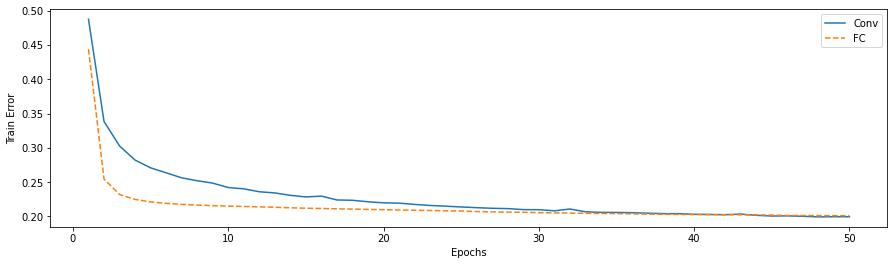

In [19]:
epochs = [i for i in range(1,NUM_EPOCHS+1)]

fig, ax = plt.subplots(figsize=(15,4))
ax.set_xlabel('Epochs')
ax.set_ylabel('Train Error')
ax.plot(epochs, train_loss, label='Conv')
ax.plot(epochs, train_error_512, linestyle='--', label='FC')
ax.legend()

plt.show()

The next image allows making the same comparison as the previous one but for the error of the test set.

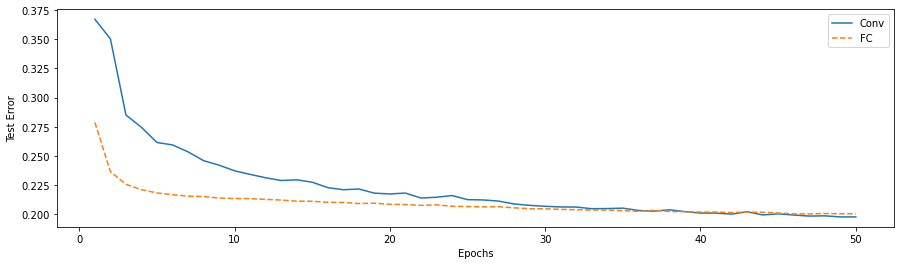

In [20]:
epochs = [i for i in range(1,NUM_EPOCHS+1)]

fig, ax = plt.subplots(figsize=(15,4))

ax.set_xlabel('Epochs')
ax.set_ylabel('Test Error')
ax.plot(epochs, test_loss, label='Conv')
ax.plot(epochs, test_error_512, linestyle='--', label='FC')
ax.legend()

plt.show()

In [21]:
# autoencoder that implements one hidden fully-connected layer with 512 neurons
class AE(nn.Module):
    def __init__(self,hide_layer_size):
        super(AE, self).__init__()
        
        #encoder
        self.enc1 = nn.Linear(in_features=784, out_features=hide_layer_size)
        
        #decoder
        self.dec1 = nn.Linear(in_features=hide_layer_size, out_features=784)
        
        #activation function
        self.relu = nn.ReLU()
        
        #dropout
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.enc1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        x = self.dec1(x)
        x = self.relu(x)
        return x

In [22]:
# Load trained model from the last Project
autoencoder_512 = AE(512)
if torch.cuda.is_available():
    autoencoder_512.load_state_dict(torch.load(
        './AE_fully_connected_512/autoencoder_512.pth'))
else:
    autoencoder_512.load_state_dict(torch.load(
        './AE_fully_connected_512/autoencoder_512.pth',
        map_location=torch.device('cpu')))

<All keys matched successfully>

Now we are going to randomly extract digits from the test set and generate two reconstructions, one made by the convolutional autoencoder and the other by the fully-connected autoencoder.

In [23]:
# get n samples in batch format img[:n].shape = (n,1,28,28)
def image_sample(data_loader, n):
    for img,_ in data_loader:
        return img[:n]

# evaluate the convolutional network 
# with img where img.shape = (m,1,28,28)
def eval_c(net, img):
    net.eval()
    net.to(device)
    
    img = img.to(device)
    output = net(img)
    return output.data

# evaluate the fully-connected network
def eval_fc(net, img):
    net.eval()
    net.to(device)
    
    img = img.to(device)
    output = net(img.view(img.size(0), -1))
    return output.view(output.size(0), 1, 28, 28).data

# generate image grid from a batch
def image_grid(img):
    return make_grid(img, padding=0)[0]

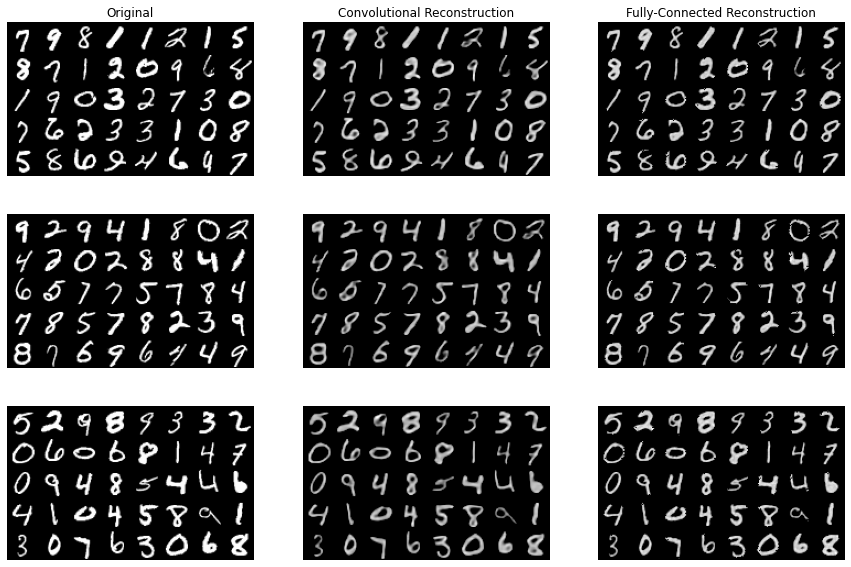

In [24]:
rows = 3
fig, ax = plt.subplots(rows, 3, figsize=(15, 10))

for i in range(rows):
    img = image_sample(test_loader, 40)
    rec_c, rec_fc = eval_c(model,img), eval_fc(autoencoder_512, img)
    ax[i][0].imshow(image_grid(img),cmap='gray')
    ax[i][0].axis('off')

    ax[i][1].imshow(image_grid(rec_c).cpu(),cmap='gray')
    ax[i][1].axis('off')

    ax[i][2].imshow(image_grid(rec_fc).cpu(),cmap='gray')
    ax[i][2].axis('off')

ax[0][0].set_title('Original')
ax[0][1].set_title('Convolutional Reconstruction')
ax[0][2].set_title('Fully-Connected Reconstruction')

plt.show()

It can be noticed that some digits reconstructed by the convolutional autoencoder appear slightly more blurred than those generated by the fully-connected autoencoder.

# Conclusions

Based on what was previously shown, we can say that a neural network model was presented with a much smaller number of trainable parameters than the fully-connected autoencoder, obtaining very similar results in the image reconstruction task. The topology of this new neural network allows extracting information from images in a more efficient and adequate way.